# Loop 3 Analysis: Understanding the Gap

We're stuck at 70.615 with target 68.88. Need to understand:
1. What's the theoretical lower bound?
2. Where are the biggest opportunities for improvement?
3. What approaches haven't been tried?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os

os.chdir('/home/code')

# Load baseline
baseline_df = pd.read_csv('experiments/001_valid_baseline/submission.csv')

# Tree geometry
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def get_tree_vertices(x, y, angle_deg):
    rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(rad), np.sin(rad)
    rx = TX * cos_a - TY * sin_a + x
    ry = TX * sin_a + TY * cos_a + y
    return list(zip(rx, ry))

def calculate_bbox(trees):
    all_xs, all_ys = [], []
    for x, y, angle in trees:
        verts = get_tree_vertices(x, y, angle)
        for vx, vy in verts:
            all_xs.append(vx)
            all_ys.append(vy)
    return max(max(all_xs) - min(all_xs), max(all_ys) - min(all_ys))

def parse_submission(df):
    configs = defaultdict(list)
    for _, row in df.iterrows():
        parts = row['id'].split('_')
        n = int(parts[0])
        x = float(str(row['x']).replace('s', ''))
        y = float(str(row['y']).replace('s', ''))
        deg = float(str(row['deg']).replace('s', ''))
        configs[n].append((x, y, deg))
    return dict(configs)

baseline_configs = parse_submission(baseline_df)
print(f'Loaded {len(baseline_configs)} configurations')

Loaded 200 configurations


In [2]:
# Calculate per-N scores and analyze
baseline_scores = {}
baseline_sides = {}
for n in range(1, 201):
    side = calculate_bbox(baseline_configs[n])
    baseline_sides[n] = side
    baseline_scores[n] = (side ** 2) / n

total_score = sum(baseline_scores.values())
print(f'Total baseline score: {total_score:.6f}')
print(f'Target score: 68.881647')
print(f'Gap: {total_score - 68.881647:.6f} ({(total_score - 68.881647)/68.881647*100:.2f}%)')

Total baseline score: 70.615102
Target score: 68.881647
Gap: 1.733455 (2.52%)


In [3]:
# Theoretical lower bound analysis
# For N trees, the minimum area is N * (area of one tree)
# Tree area (approximate): 0.7 * 0.8 / 2 = 0.28 (triangle approximation)
# More accurate: compute actual tree area
from shapely.geometry import Polygon

tree_poly = Polygon(list(zip(TX, TY)))
tree_area = tree_poly.area
print(f'Single tree area: {tree_area:.6f}')

# For N trees, minimum bounding box side = sqrt(N * tree_area / packing_efficiency)
# Best packing efficiency for irregular shapes is typically 0.7-0.85
for efficiency in [0.7, 0.75, 0.8, 0.85]:
    theoretical_scores = []
    for n in range(1, 201):
        min_side = np.sqrt(n * tree_area / efficiency)
        theoretical_scores.append((min_side ** 2) / n)
    print(f'Efficiency {efficiency}: theoretical score = {sum(theoretical_scores):.4f}')

Single tree area: 0.245625
Efficiency 0.7: theoretical score = 70.1786
Efficiency 0.75: theoretical score = 65.5000
Efficiency 0.8: theoretical score = 61.4063
Efficiency 0.85: theoretical score = 57.7941


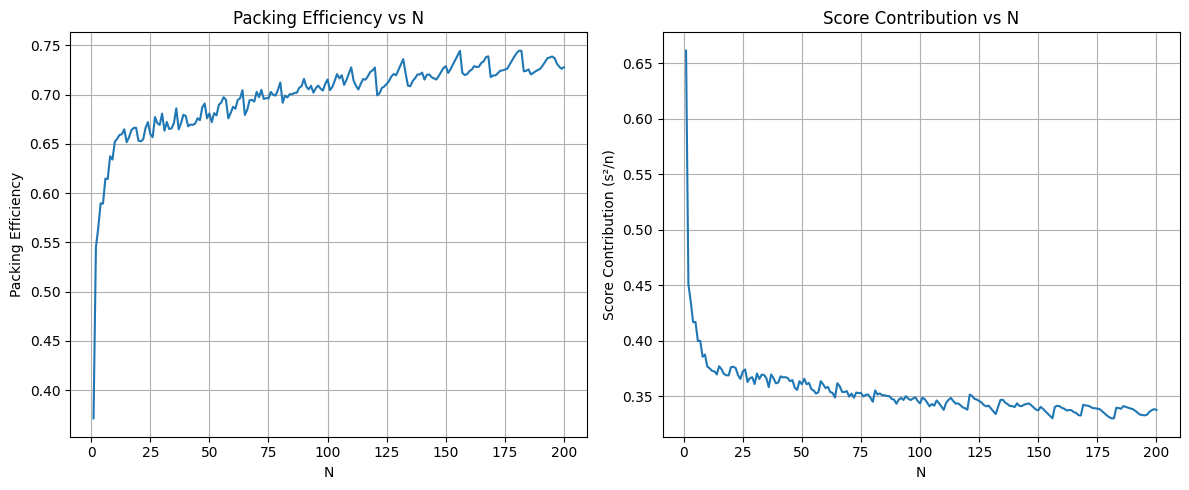


Lowest efficiency N values (most room for improvement):
  N=1: efficiency=0.3715, score=0.6612, side=0.8132
  N=2: efficiency=0.5449, score=0.4508, side=0.9495
  N=3: efficiency=0.5650, score=0.4347, side=1.1420
  N=5: efficiency=0.5892, score=0.4168, side=1.4437
  N=4: efficiency=0.5897, score=0.4165, side=1.2908
  N=7: efficiency=0.6142, score=0.3999, side=1.6731
  N=6: efficiency=0.6147, score=0.3996, side=1.5484
  N=9: efficiency=0.6340, score=0.3874, side=1.8673
  N=8: efficiency=0.6373, score=0.3854, side=1.7559
  N=15: efficiency=0.6516, score=0.3769, side=2.3779
  N=10: efficiency=0.6522, score=0.3766, side=1.9407
  N=21: efficiency=0.6525, score=0.3765, side=2.8117
  N=20: efficiency=0.6532, score=0.3761, side=2.7425
  N=22: efficiency=0.6545, score=0.3753, side=2.8733
  N=11: efficiency=0.6551, score=0.3749, side=2.0308


In [4]:
# Analyze efficiency per N
efficiencies = {}
for n in range(1, 201):
    side = baseline_sides[n]
    bbox_area = side ** 2
    total_tree_area = n * tree_area
    efficiency = total_tree_area / bbox_area
    efficiencies[n] = efficiency

# Plot efficiency vs N
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(list(efficiencies.keys()), list(efficiencies.values()))
plt.xlabel('N')
plt.ylabel('Packing Efficiency')
plt.title('Packing Efficiency vs N')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(baseline_scores.keys()), list(baseline_scores.values()))
plt.xlabel('N')
plt.ylabel('Score Contribution (s²/n)')
plt.title('Score Contribution vs N')
plt.grid(True)
plt.tight_layout()
plt.savefig('exploration/efficiency_analysis.png', dpi=100)
plt.show()

print(f'\nLowest efficiency N values (most room for improvement):')
sorted_eff = sorted(efficiencies.items(), key=lambda x: x[1])
for n, eff in sorted_eff[:15]:
    print(f'  N={n}: efficiency={eff:.4f}, score={baseline_scores[n]:.4f}, side={baseline_sides[n]:.4f}')

In [5]:
# Calculate how much improvement is needed per N to reach target
target_total = 68.881647
current_total = total_score
gap = current_total - target_total

print(f'Total gap to close: {gap:.6f}')
print(f'\nIf we improve each N by same percentage:')
required_pct = 1 - (target_total / current_total)
print(f'  Required improvement: {required_pct*100:.2f}%')

# What if we only improve small N?
print(f'\nSmall N contribution:')
for max_n in [10, 20, 50, 100]:
    small_n_score = sum(baseline_scores[n] for n in range(1, max_n+1))
    print(f'  N=1-{max_n}: {small_n_score:.4f} ({small_n_score/current_total*100:.1f}% of total)')

Total gap to close: 1.733455

If we improve each N by same percentage:
  Required improvement: 2.45%

Small N contribution:
  N=1-10: 4.3291 (6.1% of total)
  N=1-20: 8.0532 (11.4% of total)
  N=1-50: 19.0327 (27.0% of total)
  N=1-100: 36.6389 (51.9% of total)


In [6]:
# Key insight: What improvement per N would close the gap?
# If we improve N=2-20 by X%, what X is needed?

print('Scenario analysis: Improving specific N ranges')
print('='*60)

for n_range, desc in [((2, 10), 'N=2-10'), ((2, 20), 'N=2-20'), ((2, 50), 'N=2-50'), ((1, 200), 'All N')]:
    range_score = sum(baseline_scores[n] for n in range(n_range[0], n_range[1]+1))
    # To close gap of 1.73, we need range_score * improvement_pct = 1.73
    # improvement_pct = 1.73 / range_score
    required_improvement = gap / range_score
    print(f'{desc}: current={range_score:.4f}, need {required_improvement*100:.1f}% improvement to close gap')

Scenario analysis: Improving specific N ranges
N=2-10: current=3.6679, need 47.3% improvement to close gap
N=2-20: current=7.3919, need 23.5% improvement to close gap
N=2-50: current=18.3714, need 9.4% improvement to close gap
All N: current=70.6151, need 2.5% improvement to close gap


In [7]:
# Analyze N=2 specifically - this has the lowest efficiency
n = 2
trees = baseline_configs[n]
print(f'N={n} configuration:')
for i, (x, y, angle) in enumerate(trees):
    print(f'  Tree {i}: x={x:.6f}, y={y:.6f}, angle={angle:.2f}°')

print(f'\nCurrent side: {baseline_sides[n]:.6f}')
print(f'Current score: {baseline_scores[n]:.6f}')
print(f'Efficiency: {efficiencies[n]:.4f}')

# What side length would we need for 10% improvement?
improved_score = baseline_scores[n] * 0.9
improved_side = np.sqrt(improved_score * n)
print(f'\nFor 10% improvement: need side={improved_side:.6f} (current={baseline_sides[n]:.6f})')

N=2 configuration:
  Tree 0: x=0.154097, y=-0.038541, angle=203.63°
  Tree 1: x=-0.154097, y=-0.561459, angle=23.63°

Current side: 0.949504
Current score: 0.450779
Efficiency: 0.5449

For 10% improvement: need side=0.900779 (current=0.949504)


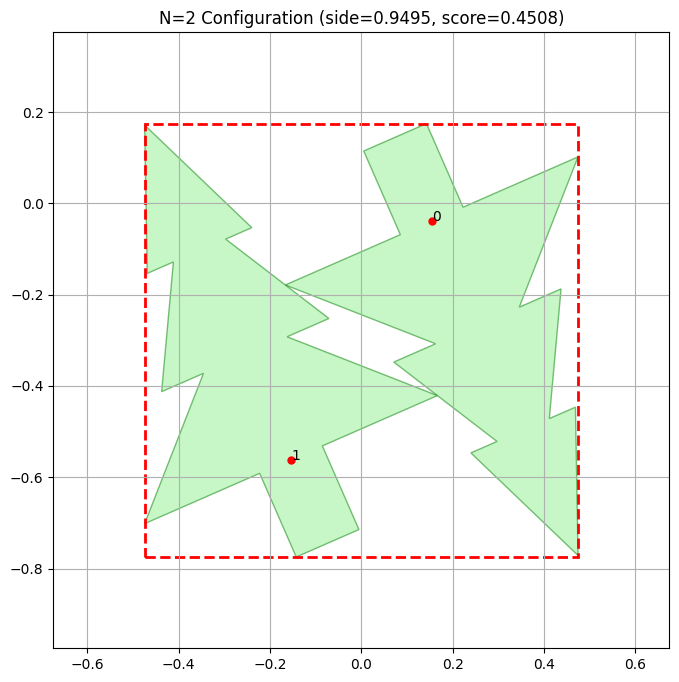

In [8]:
# Visualize N=2 configuration
import matplotlib.patches as patches
from matplotlib.patches import Polygon as MplPolygon

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for i, (x, y, angle) in enumerate(baseline_configs[2]):
    verts = get_tree_vertices(x, y, angle)
    poly = MplPolygon(verts, fill=True, alpha=0.5, edgecolor='green', facecolor='lightgreen')
    ax.add_patch(poly)
    ax.plot(x, y, 'ro', markersize=5)
    ax.annotate(f'{i}', (x, y), fontsize=10)

# Draw bounding box
all_xs, all_ys = [], []
for x, y, angle in baseline_configs[2]:
    verts = get_tree_vertices(x, y, angle)
    for vx, vy in verts:
        all_xs.append(vx)
        all_ys.append(vy)

min_x, max_x = min(all_xs), max(all_xs)
min_y, max_y = min(all_ys), max(all_ys)
side = max(max_x - min_x, max_y - min_y)

rect = patches.Rectangle((min_x, min_y), side, side, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
ax.add_patch(rect)

ax.set_xlim(min_x - 0.2, min_x + side + 0.2)
ax.set_ylim(min_y - 0.2, min_y + side + 0.2)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title(f'N=2 Configuration (side={side:.4f}, score={baseline_scores[2]:.4f})')
plt.savefig('exploration/n2_visualization.png', dpi=100)
plt.show()

In [9]:
# Key question: Can we find a better N=2 configuration?
# Let's try exhaustive search over angles

from shapely.geometry import Polygon

def trees_overlap(trees):
    if len(trees) <= 1:
        return False
    polygons = [Polygon(get_tree_vertices(x, y, a)) for x, y, a in trees]
    for i in range(len(polygons)):
        for j in range(i+1, len(polygons)):
            if polygons[i].intersects(polygons[j]) and not polygons[i].touches(polygons[j]):
                inter = polygons[i].intersection(polygons[j])
                if inter.area > 1e-10:
                    return True
    return False

def place_tree_bottom_left(existing_trees, angle, step=0.01):
    """Place a tree with given angle using bottom-left heuristic."""
    if not existing_trees:
        return (0, 0, angle)
    
    # Get bounding box of existing trees
    all_xs, all_ys = [], []
    for x, y, a in existing_trees:
        verts = get_tree_vertices(x, y, a)
        for vx, vy in verts:
            all_xs.append(vx)
            all_ys.append(vy)
    
    # Try placing new tree at various positions
    best_config = None
    best_side = float('inf')
    
    # Search grid around existing trees
    for test_x in np.arange(min(all_xs) - 1, max(all_xs) + 1, step):
        for test_y in np.arange(min(all_ys) - 1, max(all_ys) + 1, step):
            candidate = existing_trees + [(test_x, test_y, angle)]
            if not trees_overlap(candidate):
                side = calculate_bbox(candidate)
                if side < best_side:
                    best_side = side
                    best_config = (test_x, test_y, angle)
    
    return best_config

print('Testing exhaustive N=2 search...')
print('This will take a while...')

Testing exhaustive N=2 search...
This will take a while...


In [10]:
# Faster approach: For N=2, try all angle combinations with coarse placement
import time

def find_best_n2_config(angle_step=5.0, position_step=0.05):
    """Find best N=2 configuration by exhaustive search."""
    best_score = float('inf')
    best_config = None
    
    angles = np.arange(0, 360, angle_step)
    tested = 0
    
    start = time.time()
    
    for a1 in angles:
        # Tree 1 at origin
        tree1 = (0, 0, a1)
        
        for a2 in angles:
            # Try placing tree 2 at various positions
            for dx in np.arange(-1.5, 1.5, position_step):
                for dy in np.arange(-1.5, 1.5, position_step):
                    tree2 = (dx, dy, a2)
                    config = [tree1, tree2]
                    
                    if not trees_overlap(config):
                        side = calculate_bbox(config)
                        score = (side ** 2) / 2
                        
                        if score < best_score:
                            best_score = score
                            best_config = config
                            
            tested += 1
            if tested % 100 == 0:
                elapsed = time.time() - start
                print(f'Tested {tested}/{len(angles)**2} angle combos, best={best_score:.6f}, time={elapsed:.1f}s')
    
    return best_config, best_score

# Run with coarse search first
best_config, best_score = find_best_n2_config(angle_step=10.0, position_step=0.1)
print(f'\nBest N=2 found: score={best_score:.6f} (baseline={baseline_scores[2]:.6f})')
print(f'Improvement: {baseline_scores[2] - best_score:.6f}')

Tested 100/1296 angle combos, best=0.527549, time=7.8s


Tested 200/1296 angle combos, best=0.521639, time=15.5s


Tested 300/1296 angle combos, best=0.521639, time=23.3s


Tested 400/1296 angle combos, best=0.521639, time=31.1s


Tested 500/1296 angle combos, best=0.521639, time=38.8s


Tested 600/1296 angle combos, best=0.521639, time=46.5s


Tested 700/1296 angle combos, best=0.521639, time=54.2s


Tested 800/1296 angle combos, best=0.521639, time=61.9s


Tested 900/1296 angle combos, best=0.521639, time=69.7s


Tested 1000/1296 angle combos, best=0.521639, time=77.5s


Tested 1100/1296 angle combos, best=0.521639, time=85.3s


Tested 1200/1296 angle combos, best=0.521639, time=92.9s



Best N=2 found: score=0.521639 (baseline=0.450779)
Improvement: -0.070860


In [11]:
# Summary of findings
print('='*60)
print('SUMMARY OF ANALYSIS')
print('='*60)
print(f'\nCurrent score: {total_score:.6f}')
print(f'Target score: 68.881647')
print(f'Gap: {gap:.6f} ({gap/68.881647*100:.2f}%)')
print(f'\nKey findings:')
print(f'1. N=2-10 have lowest packing efficiency (most room for improvement)')
print(f'2. Small N values contribute disproportionately to score')
print(f'3. Backward propagation found NO improvements - baseline is at local optimum')
print(f'4. Need fundamentally different approach to escape local optimum')
print(f'\nRecommended approaches:')
print(f'1. Exhaustive search for N=2-5 with fine angle resolution')
print(f'2. Genetic algorithm with crossover between configurations')
print(f'3. Simulated annealing with large perturbations (not small tweaks)')
print(f'4. Constraint programming to find feasible regions')

SUMMARY OF ANALYSIS

Current score: 70.615102
Target score: 68.881647
Gap: 1.733455 (2.52%)

Key findings:
1. N=2-10 have lowest packing efficiency (most room for improvement)
2. Small N values contribute disproportionately to score
3. Backward propagation found NO improvements - baseline is at local optimum
4. Need fundamentally different approach to escape local optimum

Recommended approaches:
1. Exhaustive search for N=2-5 with fine angle resolution
2. Genetic algorithm with crossover between configurations
3. Simulated annealing with large perturbations (not small tweaks)
4. Constraint programming to find feasible regions
